In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline
from datetime import datetime 

In [70]:
# this dataset shows all NCAA match results, at a grain of one row per game
validation_data = pd.read_csv('cleaned_data/validation_dataset.csv')
validation_data.head()

,Unnamed: 0,Season,Team_ID_L,Team_ID_H,Outcome
0,0,1985,1116,1234,1
1,1,1985,1120,1345,1
2,2,1985,1207,1250,1
3,3,1985,1229,1425,1
4,4,1985,1242,1325,1


In [71]:
## Seed Data - This file identifies the seeds for all teams in each NCAA® tournament, 
# for all seasons of historical data. Thus, there are between 64-68 rows for each year,
# depending on whether there were any play-in games and how many there were.
seed_data = pd.read_csv('raw_data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seed_data['Seed'] = pd.to_numeric(seed_data['Seed'].apply(lambda x: x[1:3]))
seed_data.sample(10)

,Season,Seed,TeamID
265,1989,10,1397
117,1986,6,1412
2188,2018,4,1112
2045,2016,14,1201
149,1987,6,1344
862,1998,15,1319
1790,2012,15,1250
2071,2016,7,1333
2217,2018,16,1411
1706,2011,15,1294


In [72]:
## Seed + Match data
# we combine the above to to get a dataset with one game per row, with seed data for both teams included
temp_data = pd.merge(
    seed_data, validation_data, 
    left_on=['Season', 'TeamID'], 
    right_on=['Season', 'Team_ID_L'], 
    how='inner')

games_with_seeds = pd.merge(
    seed_data, 
    temp_data, 
    left_on=['Season', 'TeamID'], 
    right_on=['Season', 'Team_ID_H'], 
    how='inner', suffixes=['_H', '_L'])

games_with_seeds.drop(['TeamID_H', 'TeamID_L', 'Unnamed: 0'], axis=1, inplace=True)

# rename Seed_H and Seed_L so it's clear the L and H are talking about the team IDs, not the relative seed order
games_with_seeds = games_with_seeds.rename(columns={'Seed_H': 'Seed_Team_ID_H', 'Seed_L': 'Seed_Team_ID_L'})
games_with_seeds.sample(10)

,Season,Seed_Team_ID_H,Seed_Team_ID_L,Team_ID_L,Team_ID_H,Outcome
149,1987,6,14,1122,1344,0
1454,2007,16,1,1242,1310,1
2000,2016,1,4,1235,1438,0
1402,2007,5,12,1116,1425,0
1198,2003,15,2,1242,1429,1
1860,2014,11,6,1314,1344,1
90,1986,10,7,1235,1275,1
388,1991,10,3,1329,1396,0
153,1987,9,8,1246,1326,0
1081,2002,11,2,1163,1356,1


In [73]:
games_with_seeds.to_csv("cleaned_data/games_with_seeds.csv")

In [74]:
# now we're going to add a column that shows what the win percentage is for a given pair of low vs high seeds
# first, let's add columns that show the high seed and the low seed

# in our dataset, outcome is 1 if the lower team_id won, and 0 if the higher team_id won
def did_lower_seed_win(row):
    if row["Outcome"] == 1:
        winner_seed = row["Seed_Team_ID_L"]
        loser_seed = row["Seed_Team_ID_H"]
    else:
        winner_seed = row["Seed_Team_ID_H"]
        loser_seed = row["Seed_Team_ID_L"]
        
    if winner_seed < loser_seed:
        return 1
    else:
        return 0

games_with_seeds["Higher_Seed"] = games_with_seeds.apply(
    lambda row: min(row["Seed_Team_ID_H"], row["Seed_Team_ID_L"]), 
    axis = 1
)

games_with_seeds["Lower_Seed"] = games_with_seeds.apply(
    lambda row: max(row["Seed_Team_ID_L"], row["Seed_Team_ID_H"]),
    axis = 1
)

games_with_seeds["Did_Higher_Seed_Win"] = games_with_seeds.apply(
    lambda row: did_lower_seed_win(row),
    axis = 1
)

games_with_seeds.sample(10)

,Season,Seed_Team_ID_H,Seed_Team_ID_L,Team_ID_L,Team_ID_H,Outcome,Higher_Seed,Lower_Seed,Did_Higher_Seed_Win
1490,2008,2,3,1390,1400,0,2,3,1
1000,2000,8,1,1277,1458,1,1,8,1
651,1995,2,7,1153,1163,0,2,7,1
917,1999,3,6,1231,1385,0,3,6,1
1870,2014,4,12,1372,1417,0,4,12,1
605,1994,6,3,1276,1400,1,3,6,1
1904,2014,2,15,1110,1458,0,2,15,1
556,1993,3,14,1129,1435,0,3,14,1
2039,2016,3,11,1320,1401,0,3,11,1
1103,2002,9,8,1390,1443,1,8,9,1


In [75]:
# drop some of the columns we no longer need
games_with_seeds.drop(['Outcome'], axis=1, inplace=True)
games_with_seeds.sample(10)

,Season,Seed_Team_ID_H,Seed_Team_ID_L,Team_ID_L,Team_ID_H,Higher_Seed,Lower_Seed,Did_Higher_Seed_Win
1205,2004,5,4,1153,1228,4,5,0
2124,2018,3,2,1345,1403,2,3,0
2166,2018,16,9,1243,1420,9,16,1
1031,2001,3,14,1206,1268,3,14,1
95,1986,1,16,1172,1246,1,16,1
2236,2019,1,3,1345,1438,1,3,1
1627,2010,9,1,1242,1320,1,9,0
1453,2007,15,2,1417,1451,2,15,1
1697,2011,16,16,1114,1421,16,16,0
357,1990,12,5,1261,1437,5,12,1


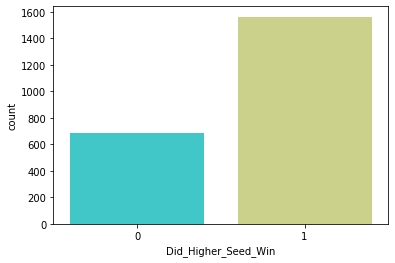

In [76]:
# How much more often did the higher seed win?
sns.countplot(x='Did_Higher_Seed_Win',data=games_with_seeds,palette='rainbow')

In [77]:
# For a given pair of (high_seed, low_seed), what percentage of the time did high_seed win?

games_with_seeds["High_Seed_Win_Percentage"] = games_with_seeds.groupby(
    ['Higher_Seed', 'Lower_Seed']
)['Did_Higher_Seed_Win'].transform(lambda x: x.mean())

games_with_seeds["Frequency_of_Seed_Matchup"] = games_with_seeds.groupby(
    ['Higher_Seed', 'Lower_Seed']
)['Did_Higher_Seed_Win'].transform(lambda x: x.count())
games_with_seeds.sample(10)

,Season,Seed_Team_ID_H,Seed_Team_ID_L,Team_ID_L,Team_ID_H,Higher_Seed,Lower_Seed,Did_Higher_Seed_Win,High_Seed_Win_Percentage,Frequency_of_Seed_Matchup
97,1986,3,14,1123,1272,3,14,1,0.850000,140
1994,2016,8,9,1344,1425,8,9,0,0.485714,140
481,1992,9,8,1191,1431,8,9,0,0.485714,140
1431,2007,7,3,1332,1424,3,7,1,0.600000,15
1525,2009,3,6,1417,1437,3,6,1,0.611111,72
2194,2019,9,1,1181,1416,1,9,1,0.916667,72
1904,2014,2,15,1110,1458,2,15,1,0.942857,140
449,1992,6,3,1269,1393,3,6,1,0.611111,72
662,1995,1,16,1159,1242,1,16,1,0.992857,140
387,1991,10,1,1314,1396,1,10,1,0.833333,6


In [78]:
games_with_seeds.to_csv("cleaned_data/seed_win_percentages.csv")

In [80]:
def assign_win_percentage_of_lower_team_id_based_on_seed_matchup(row):
    if row["Lower_Seed"] == row["Higher_Seed"]:
        return 0.5
    
    if (row["Seed_Team_ID_L"] == row["Higher_Seed"]):
        return row["High_Seed_Win_Percentage"]
    else:
        return (1 - row["High_Seed_Win_Percentage"])
    
games_with_seeds["Seed_Matchup_Probability"] = games_with_seeds.apply(
    lambda row: assign_win_percentage_of_lower_team_id_based_on_seed_matchup(row),
    axis=1
)
games_with_seeds.sample(10)

,Season,Seed_Team_ID_H,Seed_Team_ID_L,Team_ID_L,Team_ID_H,Higher_Seed,Lower_Seed,Did_Higher_Seed_Win,High_Seed_Win_Percentage,Frequency_of_Seed_Matchup,Seed_Matchup_Probability
260,1989,11,2,1181,1278,2,11,1,0.875000,16,0.875000
270,1989,3,11,1191,1371,3,11,1,0.653061,49,0.346939
1257,2004,10,3,1210,1305,3,10,1,0.692308,13,0.692308
1405,2007,9,8,1266,1277,8,9,0,0.485714,140,0.485714
2235,2019,1,5,1120,1438,1,5,1,0.829787,47,0.170213
1306,2005,11,6,1428,1431,6,11,1,0.628571,140,0.628571
864,1998,13,8,1348,1434,8,13,1,1.000000,1,1.000000
1139,2003,2,15,1190,1448,2,15,1,0.942857,140,0.057143
1187,2003,2,10,1113,1242,2,10,1,0.640000,50,0.360000
2209,2019,3,14,1297,1403,3,14,1,0.850000,140,0.150000


In [81]:
output_data = games_with_seeds[["Season", "Team_ID_H", "Team_ID_L", "Seed_Matchup_Probability"]]
output_data.sample(10)

,Season,Team_ID_H,Team_ID_L,Seed_Matchup_Probability
852,1998,1345,1174,0.057143
336,1990,1314,1116,0.444444
177,1987,1338,1328,0.388889
82,1986,1277,1242,0.829787
1870,2014,1417,1372,0.315789
430,1991,1371,1166,0.346939
1283,2005,1356,1329,0.695122
705,1996,1390,1133,0.485714
400,1991,1242,1181,0.607143
918,1999,1385,1359,0.150000


In [82]:
output_data.to_csv("cleaned_data/seed_matchup_probabilities.csv")